In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

Global seed set to 0


In [3]:
scv.set_figure_params()

In [90]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [91]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [92]:
adata.uns["skeleton"].shape

(280, 280)

In [93]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [94]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [95]:
adata.layers["Ms"].max()

39747.324

In [96]:
adata.X = np.log1p(adata.X.copy())

In [97]:
adata = preprocess_data(adata,min_max_scale=False,filter_on_r2 = True)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]
adata = preprocess_data(adata,filter_on_r2 = False)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 132


In [71]:
adata.uns["Ms"].max()

12968.118

In [72]:
adata.uns["skeleton"]

,A4_TF1,A4_TF3,A5_TF1,A6_TF1,A6_TF2,A6_TF3,A6_TF4,B10_TF1,B10_TF2,B11_TF1,...,Target43,Target44,Target45,Target47,Target48,Target5,Target50,Target6,Target7,Target9
A3_TF3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3_TF4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3_TF5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3_TF6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4_TF3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D3_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D3_TF2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D3_TF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D4_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
adata.uns["skeleton"].shape

(88, 132)

In [74]:
adata.layers["Mu"]

array([[2.2237231e-01, 4.7074676e-01, 4.6435753e-01, ..., 3.8069826e-01,
        3.5754797e-01, 5.5074126e-01],
       [3.9832376e-02, 3.7840270e-02, 9.4398372e-02, ..., 3.7499794e-01,
        6.6738677e-01, 5.8145988e-01],
       [2.0395366e-04, 0.0000000e+00, 0.0000000e+00, ..., 4.8186892e-01,
        5.2545571e-01, 4.0531948e-01],
       ...,
       [7.1582097e-01, 8.1019086e-01, 6.7791092e-01, ..., 2.4054891e-01,
        1.7445381e-01, 5.0284755e-01],
       [1.3497818e-03, 8.5646566e-03, 4.5474763e-03, ..., 2.5299948e-01,
        6.9176316e-01, 5.1687372e-01],
       [5.7561410e-04, 0.0000000e+00, 0.0000000e+00, ..., 2.5339793e-02,
        5.7540834e-01, 9.6220253e-03]], dtype=float32)

In [75]:
W = adata.uns["skeleton"].copy()

In [76]:
import torch
W = torch.tensor(np.array(W)).int()

In [77]:
W.shape

torch.Size([88, 132])

In [78]:
rgv_m = rgv.train.Trainer(adata, W=W.T,early_stopping = True, nepoch = 300, solver = "AdaBelief", lr = 0.0001,T_max = 300,batch_size=256,grad_clip = 5,mac_user = False)

In [79]:
rgv_m.model.dt0 = torch.full((rgv_m.model.n_targets,), 1)

In [80]:
rgv_m.model.v_encoder.alpha_unconstr_max

Parameter containing:
tensor([-0.6799, -0.0375,  0.8727,  0.3022, -0.1024, -0.7325, -0.1979, -0.5918,
         0.2138,  0.2982, -0.2387,  0.5922,  1.4983, -0.3720, -0.5728,  0.4725,
        -0.4646, -0.1028,  0.4661,  0.9101, -0.7816,  0.6144, -0.3341, -0.0387,
        -0.3137,  0.1257,  1.9066, -0.2156,  0.7082,  2.7270,  0.1143, -2.3410,
        -0.9671,  1.1150,  0.6602,  0.3613,  1.7076, -1.4419, -0.8584, -0.4960,
        -0.1204,  0.1885, -1.6682, -0.8492, -1.2085,  1.6439, -0.2954,  2.1749,
        -1.0170, -0.3266, -0.5893, -0.3560,  0.0273,  2.1184,  1.2794, -0.9144,
         1.6062,  0.8499, -0.4278,  0.1873,  1.1919,  0.0203,  0.8874,  0.1558,
        -1.3181,  0.0679, -0.3598, -0.6984, -0.2952,  1.2254,  0.6033, -1.1342,
        -1.7034, -0.9220,  0.7553, -1.1495, -1.0336,  0.1165, -1.5876, -1.0863,
         0.4749, -1.2661, -1.3982, -0.1453, -0.3760, -0.3818,  0.5832, -0.6679,
         1.5318, -0.6565,  0.8855,  0.5103,  1.1195, -0.0505,  0.4206, -1.3302,
         0.6752,  

In [81]:
rgv_m.model.decoder.t_encoder[0].weight

Parameter containing:
tensor([[-0.0300,  0.0117, -0.0227,  ..., -0.0661, -0.0234, -0.0480],
        [ 0.0589,  0.0260,  0.0277,  ...,  0.0572, -0.0429,  0.0349],
        [ 0.0730, -0.0639,  0.0157,  ..., -0.0285, -0.0142, -0.0339],
        ...,
        [ 0.0221,  0.0338,  0.0467,  ..., -0.0591, -0.0571,  0.0003],
        [-0.0531,  0.0152, -0.0206,  ...,  0.0860, -0.0145,  0.0669],
        [ 0.0775, -0.0596,  0.0443,  ..., -0.0473, -0.0318,  0.0748]],
       requires_grad=True)

In [82]:
rgv_m.train()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|██████████████████████████████████████| 300/300 [03:03<00:00,  1.63epoch/s, train_loss=57.2, val_loss=23.8]


In [118]:
rgv_m.model.max_time_unconstr

AttributeError: 'regODE' object has no attribute 'max_time_unconstr'

In [83]:
rgv_m.log.keys()

dict_keys(['train_loss', 'validation_loss', 'train_recon_loss_reg', 'val_recon_loss_reg', 'train_recon_loss_target', 'val_recon_loss_target', 'train_kl_div', 'val_kl_div'])

In [84]:
adata.layers["Ms"].max()

1.0000001

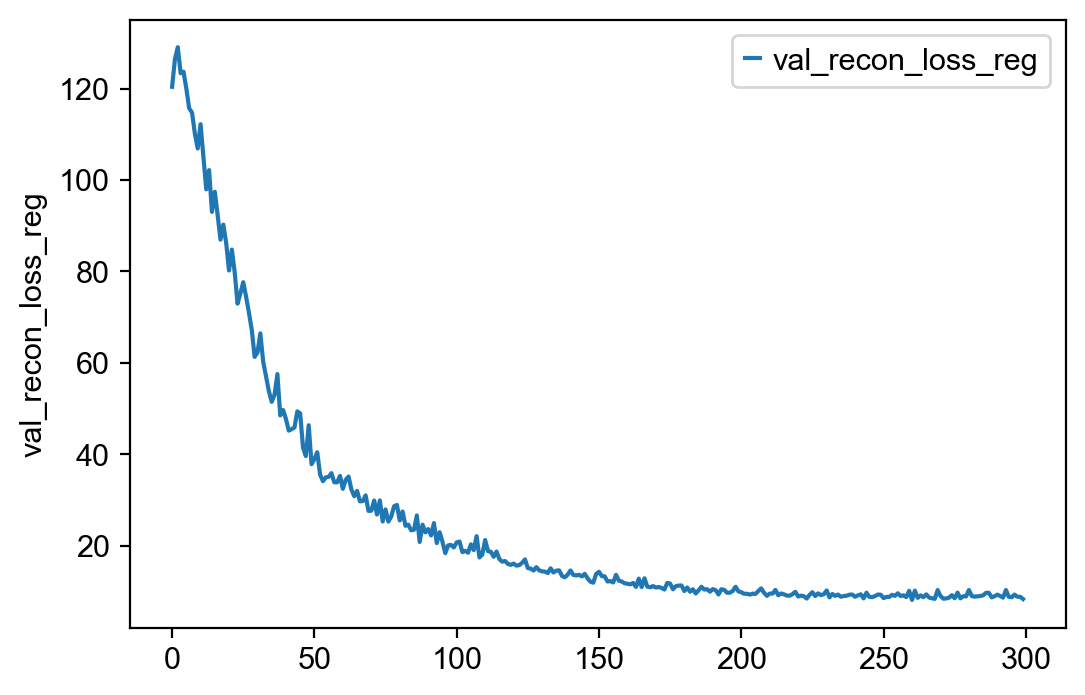

In [85]:
rgv_m.log['val_kl_div']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_reg")
ax.set_ylabel("val_recon_loss_reg")
ax.legend()
plt.show()

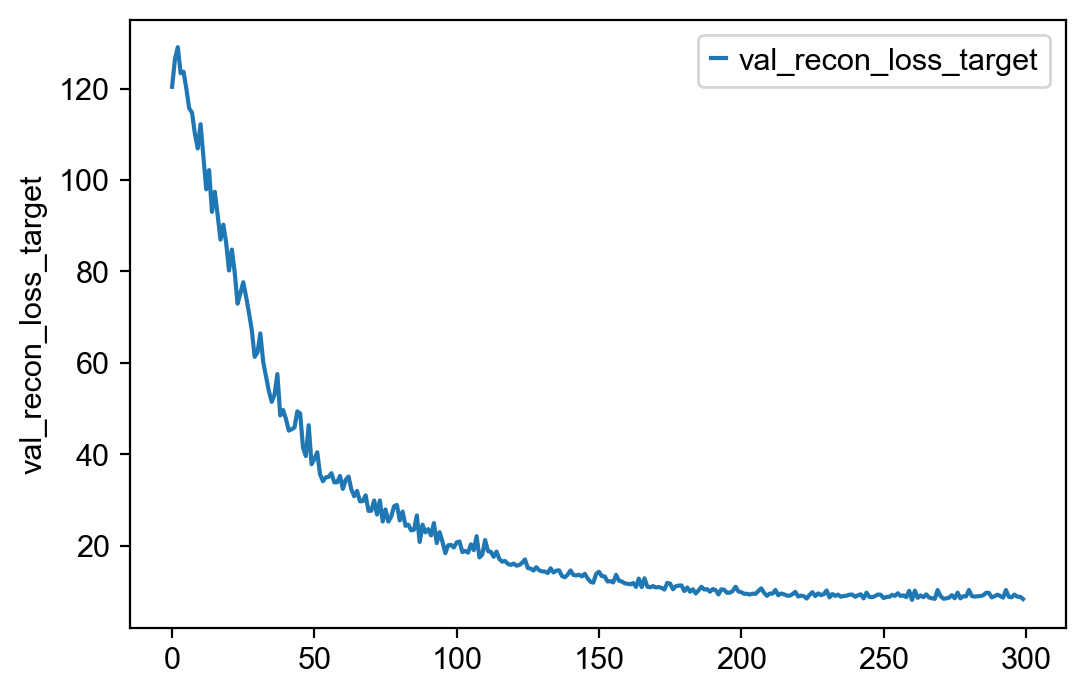

In [86]:
rgv_m.log['val_recon_loss_target']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_target")
ax.set_ylabel("val_recon_loss_target")
ax.legend()
plt.show()

In [98]:
from torch.distributions import Normal
import torch.nn.functional as F
import torchode as to
def get_time_and_velocity(adata_raw, self,n_samples = 1, sim_dynamics = False) -> np.ndarray:
        """
        Get the developmental pseudotime for all cells.

        Returns
        ----------
        :class:`~numpy.ndarray`
            The estimated pseudotime of cells.
        """

        self.model.eval()
        ### processing adata
        adata = adata_raw.copy()
        target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        adata = adata[:,target_index]
        
        ### compute latent time
        X = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
        X = torch.tensor(X).to(self.device)
        #ts, _, _ = self.model.encoder(X)
        qz_m, qz_v, z = self.model.z_encoder(X)
        T = self.model.decoder(z).sigmoid() * 20
        
        if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.model.z_encoder.z_transformation(untran_z)
            T = self.model.decoder(z).sigmoid() * 20
            T = T.mean(0)
        
        latent_time = T
        col_min = torch.min(latent_time, dim=0)[0]
        col_max = torch.max(latent_time, dim=0)[0]
        # perform min-max scaling on each column
        #latent_time = (latent_time - col_min) / (col_max - col_min)
        latent_time = latent_time.detach().numpy()
        scaling = 20 / (latent_time.max(0) - latent_time.min(0))
        latent_time = (latent_time - col_min.detach().numpy()) / (col_max.detach().numpy() - col_min.detach().numpy())
        #latent_time = latent_time*scaling[np.newaxis, :]
        
        #latent_time = latent_time.detach().numpy()
        #scaling = 20 / latent_time.max(0)

        adata.layers["fit_t"] = latent_time
        
        ### compute velocity    
        if sim_dynamics:
            unspliced = torch.tensor(adata.uns["Mu"].T).to(self.device)
            spliced = torch.tensor(adata.uns["Ms"].T).to(self.device)
            ## split spliced matrix into regulator spliced and target spliced
            regulator_spliced = spliced[self.model.regulator_index,:]
            target_spliced = spliced[self.model.target_index,:]
            target_unspliced = unspliced[self.model.target_index,:]
            
            T = T.T
            ## T is a N*G matrix (G:number of target gene, N:number of cells)
            ## ordering each raw of T
            indices = torch.argsort(T, dim=1)

            t_eval = torch.gather(T, dim = 1, index = indices)
            target_spliced = torch.gather(target_spliced, dim = 1, index = indices)
            target_unspliced = torch.gather(target_unspliced, dim = 1, index = indices)
            
            index2 = (t_eval[:,:-1] != t_eval[:,1:])
            ## estimate the shift value
            subtraction_values,_ = torch.where((t_eval[:,1:] - t_eval[:,:-1])>0, (t_eval[:,1:] - t_eval[:,:-1]), torch.inf).min(axis=1)
            ## replace inf value = 0
            subtraction_values[subtraction_values == float("Inf")] = 0

            true_tensor = torch.ones((t_eval.shape[0],1), dtype=torch.bool)
            index2 = torch.cat((index2, true_tensor.to(index2.device)),dim=1) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
            
            subtraction_values = subtraction_values[None, :].repeat(index2.shape[1], 1).T
            t_eval[index2 == False] -= subtraction_values[index2 == False]*0.1
            ## extract initial target gene expression value
            x0 = torch.cat((target_unspliced[:,0].reshape((target_unspliced.shape[0],1)),target_spliced[:,0].reshape((target_spliced.shape[0],1))),dim = 1)
            #x0 = x0.double()
            ## set up G batches, Each G represent a module (a target gene centerred regulon)
            ## infer the observe gene expression through ODE solver based on x0, t, and velocity_encoder
            #indices = torch.arange(0, x0.shape[0]).reshape((x0.shape[0],1))

            term = to.ODETerm(self.model.v_encoder)
            step_method = to.Dopri5(term=term)
            #step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
            step_size_controller = to.FixedStepController()
            solver = to.AutoDiffAdjoint(step_method, step_size_controller)
            #jit_solver = torch.jit.script(solver)
            dt0 = torch.full((x0.shape[0],), 1)
            sol = solver.solve(to.InitialValueProblem(y0=x0, t_eval=t_eval),dt0=dt0)
            
            # the solved results are saved in sol.ys [the number of subsystems, time_stamps, [u,s]]
            pred_u = sol.ys[:,:,0]
            pred_s = sol.ys[:,:,1]
        
            unspliced = torch.zeros_like(pred_u)
            unspliced.scatter_(1, indices, pred_u)
            spliced = torch.zeros_like(pred_s)
            spliced.scatter_(1, indices, pred_s)
            unspliced = unspliced.detach().numpy().T
            spliced = spliced.detach().numpy().T
        else:
            unspliced = adata.layers["Mu"]
            spliced = adata.layers["Ms"]
            
        beta = torch.clamp(F.softplus(self.model.v_encoder.beta_mean_unconstr), 0, 50)
        gamma = torch.clamp(F.softplus(self.model.v_encoder.gamma_mean_unconstr), 0, 50)  
        velocity = unspliced*beta.detach().numpy() - spliced*gamma.detach().numpy()
        
        adata.layers["velocity"] = velocity / scaling
        
        return adata

In [99]:
sum(rgv_m.model.target_index)

132

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


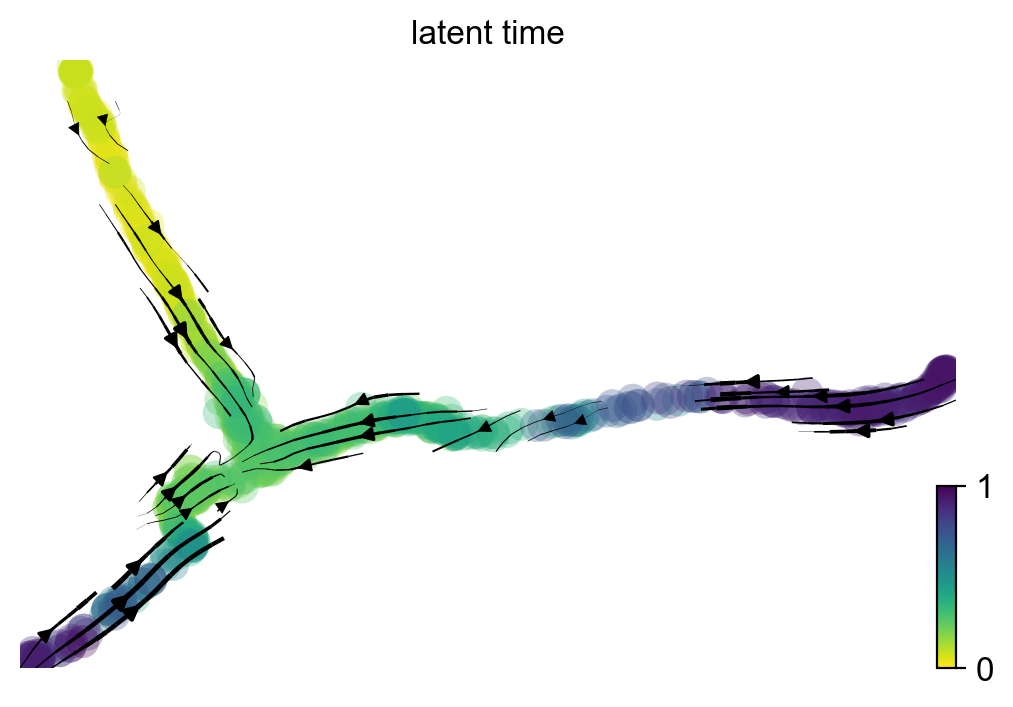

In [100]:
adata_target = get_time_and_velocity(adata,rgv_m,n_samples = 25,sim_dynamics = False)
scv.tl.velocity_graph(adata_target)
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [101]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.7717186961446905, pvalue=2.1887879208447603e-198)

In [106]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:132,132:(132*2)])

In [105]:
adata_target

AnnData object with n_obs × n_vars = 1000 × 132
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'velocity_params', 'Ms', 'Mu', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred', 'velocity_dimred'
    varm: 'PCs'
    layers: 'counts_protein', 'counts_spliced', 'counts_unsplice

In [107]:
corr = corr[~np.isnan(corr)]
corr.mean()

0.041918435878285566

In [45]:
corr_regvelo_decouple = corr.copy()

In [108]:
GRN = rgv_m.model.v_encoder.mask_m * rgv_m.model.v_encoder.grn

In [109]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [110]:
pre = GRN[rgv_m.model.v_encoder.mask_m==1]

In [111]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [112]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [114]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre2.detach().numpy()),np.abs(gt))
corr

0.18230885120445395

In [59]:
### run velovi

In [191]:
from velovi import preprocess_data, VELOVI

In [192]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [193]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.37it/s, loss=-746, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.53it/s, loss=-746, v_num=1]


In [201]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    

add_velovi_outputs_to_adata(adata, vae)

In [202]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


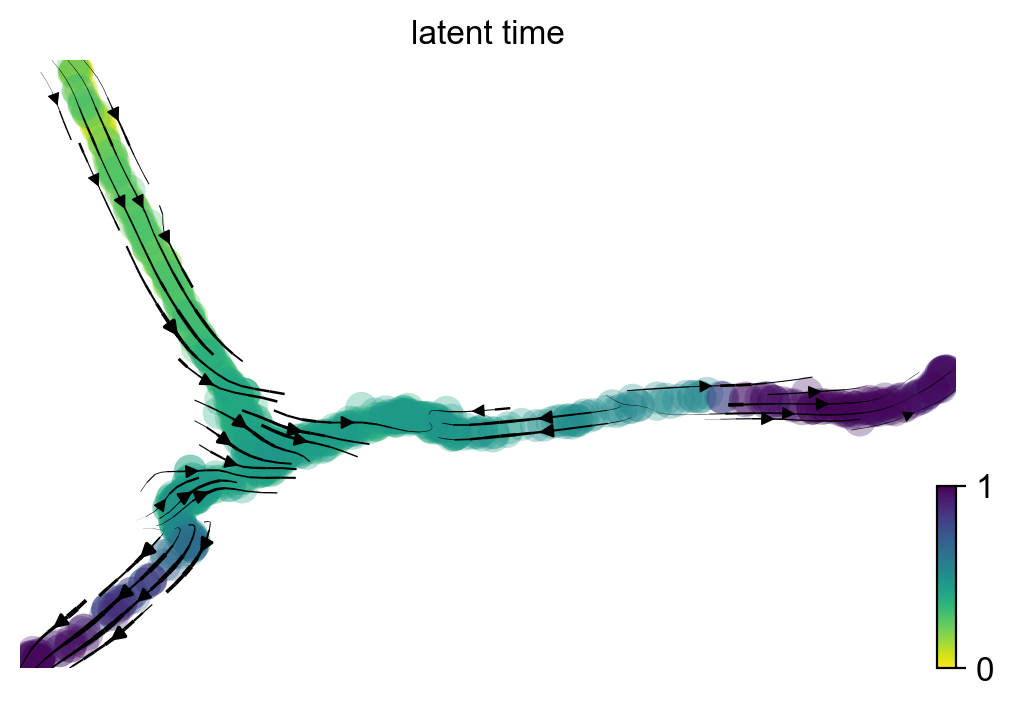

In [203]:
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [84]:
import scipy
scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.9103549114830566, pvalue=0.0)

In [85]:
adata

AnnData object with n_obs × n_vars = 1000 × 200
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'Ms', 'Mu', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred',

In [86]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:200,200:(200*2)])

In [87]:
corr.mean()

0.12836696739534306

In [88]:
corr_velovi = corr.copy()

In [89]:
adata

AnnData object with n_obs × n_vars = 1000 × 200
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'Ms', 'Mu', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred',

In [668]:
######## running coupling model
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import RegVelo as rgv

In [669]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [670]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [671]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [672]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=210)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 210 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [673]:
adata.X = np.log1p(adata.X.copy())

In [674]:
W = adata.uns["skeleton"].copy()

In [675]:
features = [i in adata.var.index.values for i in adata.uns["regulators"]]
W = W[features,:]
W = W[:,features]

In [676]:
import torch
W = torch.tensor(W).int()

In [677]:
rgv_m = rgv.train.Trainer(adata, loss_mode='mse',W=W.T, solver = "AdamW",early_stopping = False, scheduler = "CyclicLR", batch_size = 128,nepoch = 500, n_latent = 20,lr = 0.01,wt_decay = 0.01)

In [680]:
rgv_m.model.lode_func.o

Parameter containing:
tensor([ 3.3964, -0.5674, -0.4738,  1.7399, -0.6576,  0.1883, -0.4127,  0.4749,
         0.1942,  1.5694, -0.3816,  1.3925, -1.0284, -1.6206, -0.1935,  0.8075,
         0.4370, -0.0965,  0.3296, -0.1871,  1.0590, -0.0157,  1.2741,  0.0095,
         0.2156, -0.9143,  1.5568, -3.1472,  1.4018,  1.0812,  0.7874, -0.1369,
        -0.0146,  1.2227,  1.5905, -1.6282,  1.0501,  0.1182,  0.9300,  1.2441,
        -1.0897,  1.6764, -0.8788,  0.5790,  0.5862,  0.9113, -0.3519, -0.3419,
        -0.1637, -0.9694, -1.0288,  0.6462, -1.4554, -0.2811, -1.0279, -0.6871,
         0.2191, -1.6955,  1.3069, -1.6580,  1.7311,  0.6656, -1.0391, -1.3990,
         0.2094,  0.0299,  1.7059, -0.7243, -1.4503, -0.0474,  1.4969,  0.5421,
         0.7379,  1.2507, -0.4436,  0.8168,  0.0125,  0.9737, -0.0080, -0.0398,
         0.0361, -0.3415, -0.3809, -0.0568, -0.8752,  0.5213,  0.4611, -1.3266,
         0.5099, -0.2853,  0.3345,  1.1697, -0.4031, -0.3257,  0.7468, -0.1948,
        -0.6858, -

In [681]:
rgv_m.train()

Epoch 4:   1%|▎                                   | 4/500 [00:03<06:25,  1.29epoch/s, train_loss=1.25e+9, val_loss=1.32e+9]


KeyboardInterrupt: 

In [111]:
adata.obs["sim_time"]

cell1         0.000000
cell2        78.083333
cell3       372.083333
cell4       172.000000
cell5        92.083333
               ...    
cell996     348.083333
cell997      26.083333
cell998      10.000000
cell999      34.083333
cell1000    390.083333
Name: sim_time, Length: 1000, dtype: float64

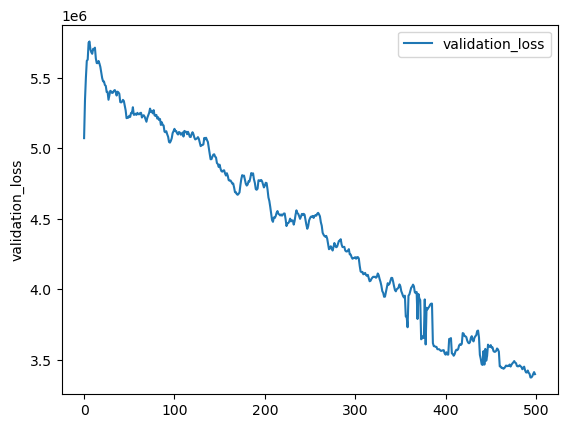

In [112]:
rgv_m.log['validation_loss']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['validation_loss'], label="validation_loss")
ax.set_ylabel("validation_loss")
ax.legend()
plt.show()

In [113]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        new_velo = model.lode_func(T, pred_x).cpu().detach().numpy()
        
        ## insert into the velocity matrix
        insert = [adata.obs.index.tolist().index(i) for i in id]
        for i in insert:
            velo[i,:] = new_velo[i,:]

    return velo

In [114]:
adata.obs["ptime"] = rgv_m.get_time()
velocity = get_vector_field(rgv_m,T=adata.obs['ptime'].values)

In [115]:
velocity = torch.tensor(velocity)

In [116]:
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]

In [117]:
ds.shape

torch.Size([1000, 210])

In [118]:
adata.layers["velocity"] = ds

In [119]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


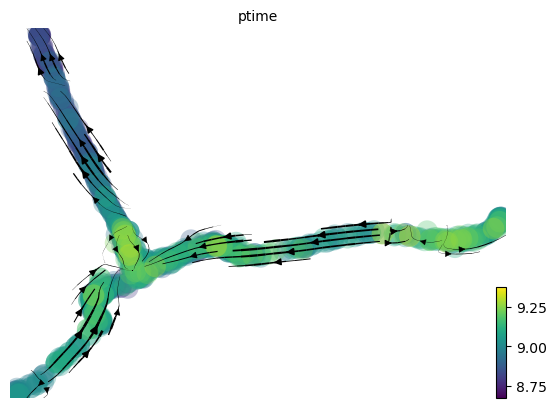

In [120]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'ptime')

In [36]:
import scipy
scipy.stats.spearmanr(adata.obs["ptime"], adata.obs["sim_time"])

SignificanceResult(statistic=0.47871923571087066, pvalue=2.05347711459399e-58)

In [92]:
corr_couple = pd.read_csv("coupling_velo_corr_v3.csv")

In [93]:
corr_couple = corr_couple.iloc[:,1]

In [120]:
corr

array([-5.66514485e-02,  2.98534764e-02,  2.07755491e-02, -2.17979287e-02,
       -4.35279581e-02, -4.28762179e-02,  5.06103204e-03, -5.62783804e-02,
       -4.73946996e-02, -2.26397002e-01, -2.25245342e-01, -3.83129292e-01,
       -2.06743103e-01, -1.22011296e-01, -1.47622116e-01, -1.81328338e-01,
       -2.30770773e-01, -1.10080509e-01, -9.68121573e-02,  1.58008437e-01,
        8.76693422e-02, -3.69590290e-02, -1.66616763e-01, -5.73109447e-02,
       -9.68315668e-02, -1.35445832e-01, -2.30256974e-01,  1.80072865e-01,
        3.93550259e-01,  1.65066565e-01,  1.92605190e-01,  5.30052524e-01,
        4.50053632e-01,  5.44702975e-01,  5.56524411e-01,  4.89504768e-01,
        4.56007728e-01,  3.96639501e-01,  6.99370399e-01,  4.56208651e-01,
        5.24294464e-01,  4.68478611e-01,  5.03987577e-01,  5.19593567e-01,
        3.95015053e-01,  3.48814664e-01,  5.22238629e-01,  5.56292316e-01,
        5.80198046e-01,  7.23951691e-01,  3.07406045e-01,  6.71778399e-01,
        3.16766663e-01,  

In [122]:
corr1 = pd.DataFrame(corr_regvelo_decouple).assign(Model="RegVelo_decouple")
corr2 = pd.DataFrame(corr).assign(Model="RegVelo_decouple_min_max")
#corr2 = pd.DataFrame(corr_couple).assign(Model="RegVelo_couple")

cdf = pd.concat([corr1,corr2])    

In [123]:
mdf = pd.melt(cdf, id_vars=['Model'], var_name=['Number'])

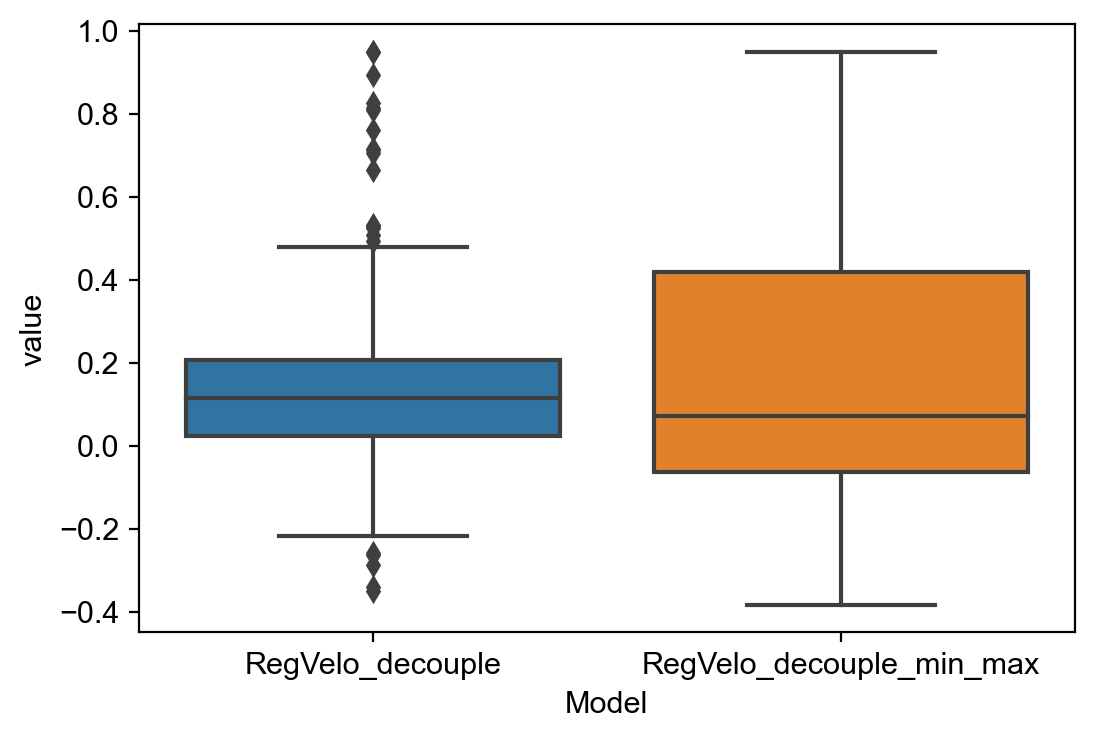

In [124]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.boxplot(x="Model", y="value", data=mdf)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

# Benchmark on cycling

In [541]:
adata = sc.read_h5ad("dataset_cycle.h5ad")

In [542]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [543]:
adata.uns["skeleton"].shape

(260, 260)

In [544]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [545]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=260)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 43 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [546]:
adata.layers["Ms"].max()

25811.777

In [547]:
adata.X = np.log1p(adata.X.copy())

In [548]:
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]
adata = preprocess_data(adata,filter_on_r2 = False)

num regulators: 105
num targets: 176


In [549]:
adata.uns["Ms"].max()

25811.777

In [550]:
adata.uns["skeleton"]

,A1_TF1,A1_TF2,A1_TF3,A2_TF1,A2_TF2,A2_TF3,A3_TF1,A3_TF2,A3_TF3,A3_TF4,...,Target46,Target47,Target48,Target49,Target5,Target50,Target6,Target7,Target8,Target9
A1_TF1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1_TF2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1_TF3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2_TF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2_TF2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HK5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HK8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HK9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [551]:
adata.uns["skeleton"].shape

(105, 176)

In [552]:
adata.layers["Mu"]

array([[5.4920715e-01, 5.8099717e-01, 7.3292381e-01, ..., 3.3541739e-01,
        1.4378214e-02, 8.0500621e-01],
       [8.8337237e-01, 8.0902845e-01, 7.7909327e-01, ..., 8.6425786e-04,
        5.3228325e-01, 5.5572581e-03],
       [8.9169431e-01, 8.1967115e-01, 8.7278289e-01, ..., 0.0000000e+00,
        6.9838649e-01, 0.0000000e+00],
       ...,
       [3.0528954e-01, 1.8245396e-01, 2.0940045e-01, ..., 0.0000000e+00,
        8.2704747e-01, 0.0000000e+00],
       [3.8816261e-01, 3.4586084e-01, 3.7732592e-01, ..., 0.0000000e+00,
        7.5679374e-01, 0.0000000e+00],
       [9.8227058e-05, 1.3638688e-04, 1.3005127e-04, ..., 8.2582825e-01,
        1.2991757e-03, 8.8048071e-01]], dtype=float32)

In [553]:
W = adata.uns["skeleton"].copy()

In [554]:
import torch
W = torch.tensor(np.array(W)).int()

In [555]:
W.shape

torch.Size([105, 176])

In [556]:
rgv_m = rgv.train.Trainer(adata, W=W.T,early_stopping = True, nepoch = 300, solver = "AdaBelief", lr = 0.0001,T_max = 300,batch_size=256,grad_clip = 5,mac_user = False)

In [557]:
rgv_m.model.dt0 = torch.full((rgv_m.model.n_targets,), 1)

In [558]:
rgv_m.model.v_encoder.alpha_unconstr_max

Parameter containing:
tensor([ 1.1685, -1.2421, -0.7661,  0.2499, -1.0497, -0.3229, -0.0729,  0.0620,
        -1.7296,  1.0146, -0.8313,  1.3458, -1.2473,  0.1112,  1.1844,  0.2132,
         1.5171, -0.2669, -0.4609,  0.5909, -1.1336, -0.3502, -0.7583, -0.2127,
        -1.4104, -0.6075, -0.2670,  0.1877, -0.7534, -0.4221,  0.3206,  1.6553,
        -0.9253,  0.2962, -0.3782,  0.1345, -0.8408,  0.1022,  0.9151,  0.1619,
         1.4451, -1.0259,  0.1832, -2.1030, -2.1165, -2.3111,  1.0100, -1.3051,
        -1.2469,  2.4087,  0.0406,  1.7524,  0.0800, -0.5221,  0.3450, -1.2077,
         0.5296,  2.5983,  1.0275,  0.3856, -0.7200, -0.6758, -0.8397, -0.6165,
        -0.2223,  0.5527,  0.8212,  0.2028, -0.2813,  1.2681,  0.6888,  1.2207,
         1.6908, -1.8160, -1.4929, -0.3204,  0.2717,  1.3825, -0.4359, -1.0320,
         0.0459, -1.3418, -0.2282,  0.3455,  1.2290,  1.0802,  0.5554, -1.0260,
        -0.1307,  0.3627,  0.3575, -0.4514, -0.4124, -1.4552, -1.0335,  0.5259,
         0.5406,  

In [559]:
rgv_m.model.decoder.t_encoder[0].weight

Parameter containing:
tensor([[ 0.0370,  0.0150, -0.0176,  ...,  0.0535, -0.0300,  0.0831],
        [-0.0453, -0.0375,  0.0735,  ..., -0.0493, -0.0803,  0.0769],
        [-0.0815, -0.0804, -0.0778,  ..., -0.0470, -0.0709,  0.0107],
        ...,
        [ 0.0176,  0.0709, -0.0187,  ..., -0.0706,  0.0009,  0.0754],
        [-0.0057,  0.0767,  0.0017,  ...,  0.0691,  0.0842, -0.0517],
        [-0.0504,  0.0449,  0.0258,  ...,  0.0261,  0.0453, -0.0661]],
       requires_grad=True)

In [560]:
rgv_m.train()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|██████████████████████████████████████| 300/300 [04:38<00:00,  1.08epoch/s, train_loss=72.5, val_loss=34.3]


In [561]:
rgv_m.log.keys()

dict_keys(['train_loss', 'validation_loss', 'train_recon_loss_reg', 'val_recon_loss_reg', 'train_recon_loss_target', 'val_recon_loss_target', 'train_kl_div', 'val_kl_div'])

In [388]:
adata = rgv_m.adata.copy()

In [389]:
adata.layers["Ms"].max()

1.0000001

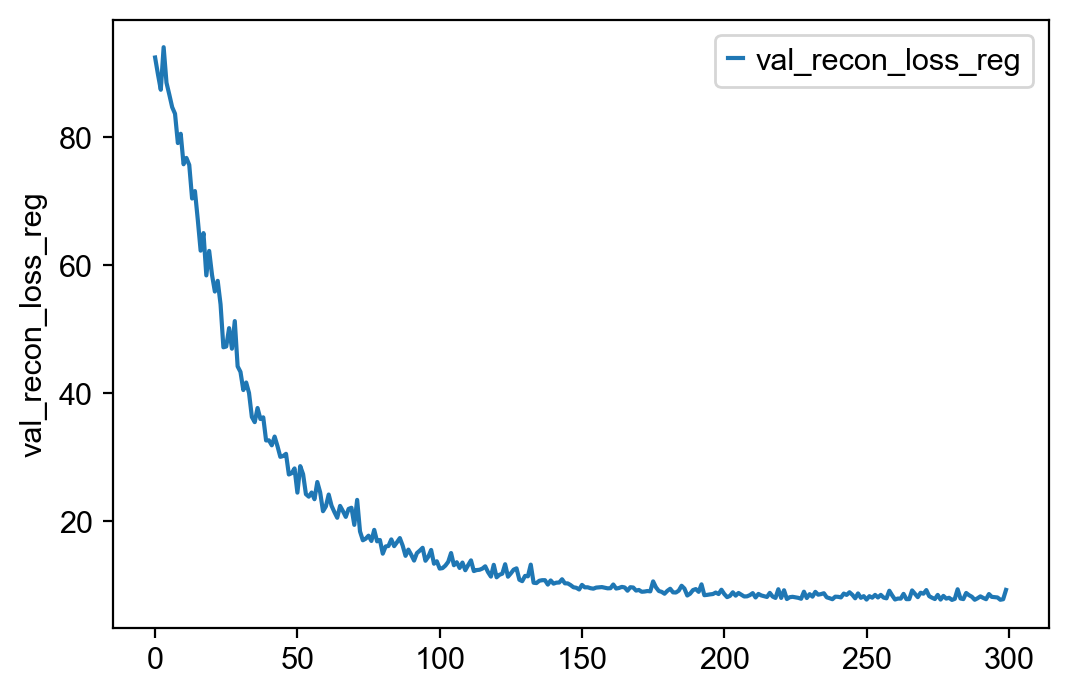

In [562]:
rgv_m.log['val_kl_div']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_reg")
ax.set_ylabel("val_recon_loss_reg")
ax.legend()
plt.show()

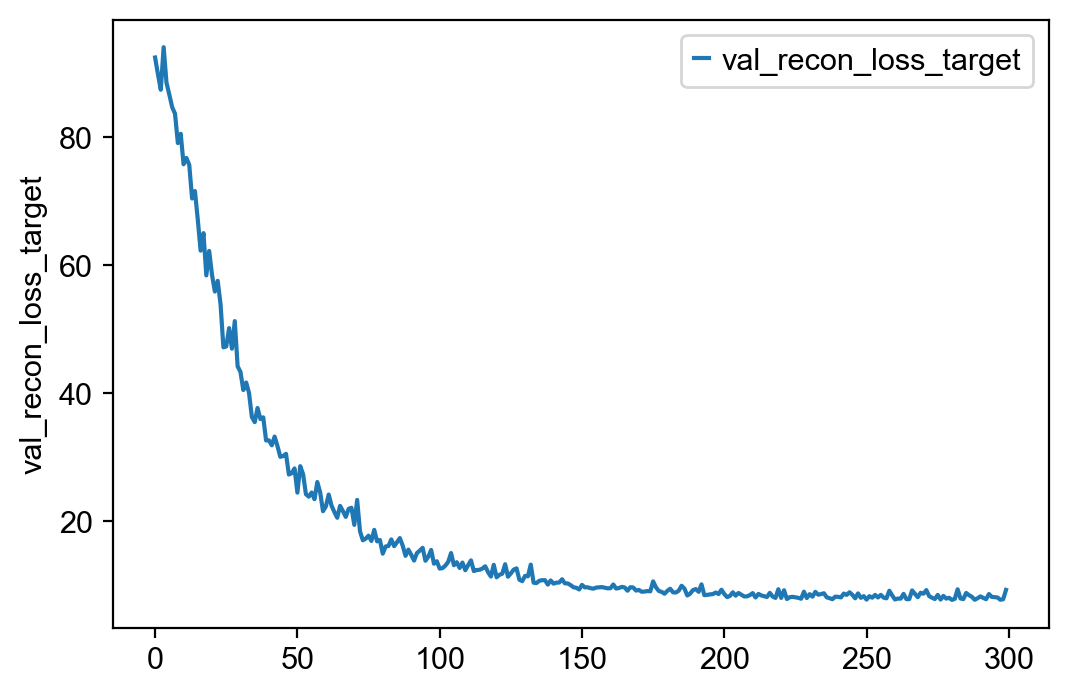

In [563]:
rgv_m.log['val_recon_loss_target']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_target")
ax.set_ylabel("val_recon_loss_target")
ax.legend()
plt.show()

In [564]:
adata

AnnData object with n_obs × n_vars = 1000 × 190
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'Ms', 'Mu'
    obsm: 'dimred', 'X_pca'
    varm: 'PCs'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts', 'rna_velocity', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [565]:
from torch.distributions import Normal
import torch.nn.functional as F
import torchode as to
def get_time_and_velocity(adata_raw, self,n_samples = 1, sim_dynamics = False) -> np.ndarray:
        """
        Get the developmental pseudotime for all cells.

        Returns
        ----------
        :class:`~numpy.ndarray`
            The estimated pseudotime of cells.
        """

        self.model.eval()
        ### processing adata
        adata = adata_raw.copy()
        target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        adata = adata[:,target_index]
        
        ### compute latent time
        X = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
        X = torch.tensor(X).to(self.device)
        #ts, _, _ = self.model.encoder(X)
        qz_m, qz_v, z = self.model.z_encoder(X)
        T = self.model.decoder(z).sigmoid() * 20
        
        if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.model.z_encoder.z_transformation(untran_z)
            T = self.model.decoder(z).sigmoid() * 20
            T = T.mean(0)
        
        latent_time = T
        col_min = torch.min(latent_time, dim=0)[0]
        col_max = torch.max(latent_time, dim=0)[0]
        # perform min-max scaling on each column
        #latent_time = (latent_time - col_min) / (col_max - col_min)
        latent_time = latent_time.detach().numpy()
        scaling = 20 / (latent_time.max(0) - latent_time.min(0))
        latent_time = (latent_time - col_min.detach().numpy()) / (col_max.detach().numpy() - col_min.detach().numpy())
        #latent_time = latent_time*scaling[np.newaxis, :]
        
        #latent_time = latent_time.detach().numpy()
        #scaling = 20 / latent_time.max(0)

        adata.layers["fit_t"] = latent_time
        
        ### compute velocity    
        if sim_dynamics:
            unspliced = torch.tensor(adata.uns["Mu"].T).to(self.device)
            spliced = torch.tensor(adata.uns["Ms"].T).to(self.device)
            ## split spliced matrix into regulator spliced and target spliced
            regulator_spliced = spliced[self.model.regulator_index,:]
            target_spliced = spliced[self.model.target_index,:]
            target_unspliced = unspliced[self.model.target_index,:]
            
            T = T.T
            ## T is a N*G matrix (G:number of target gene, N:number of cells)
            ## ordering each raw of T
            indices = torch.argsort(T, dim=1)

            t_eval = torch.gather(T, dim = 1, index = indices)
            target_spliced = torch.gather(target_spliced, dim = 1, index = indices)
            target_unspliced = torch.gather(target_unspliced, dim = 1, index = indices)
            
            index2 = (t_eval[:,:-1] != t_eval[:,1:])
            ## estimate the shift value
            subtraction_values,_ = torch.where((t_eval[:,1:] - t_eval[:,:-1])>0, (t_eval[:,1:] - t_eval[:,:-1]), torch.inf).min(axis=1)
            ## replace inf value = 0
            subtraction_values[subtraction_values == float("Inf")] = 0

            true_tensor = torch.ones((t_eval.shape[0],1), dtype=torch.bool)
            index2 = torch.cat((index2, true_tensor.to(index2.device)),dim=1) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
            
            subtraction_values = subtraction_values[None, :].repeat(index2.shape[1], 1).T
            t_eval[index2 == False] -= subtraction_values[index2 == False]*0.1
            ## extract initial target gene expression value
            x0 = torch.cat((target_unspliced[:,0].reshape((target_unspliced.shape[0],1)),target_spliced[:,0].reshape((target_spliced.shape[0],1))),dim = 1)
            #x0 = x0.double()
            ## set up G batches, Each G represent a module (a target gene centerred regulon)
            ## infer the observe gene expression through ODE solver based on x0, t, and velocity_encoder
            #indices = torch.arange(0, x0.shape[0]).reshape((x0.shape[0],1))

            term = to.ODETerm(self.model.v_encoder)
            step_method = to.Dopri5(term=term)
            #step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
            step_size_controller = to.FixedStepController()
            solver = to.AutoDiffAdjoint(step_method, step_size_controller)
            #jit_solver = torch.jit.script(solver)
            dt0 = torch.full((x0.shape[0],), 1)
            sol = solver.solve(to.InitialValueProblem(y0=x0, t_eval=t_eval),dt0=dt0)
            
            # the solved results are saved in sol.ys [the number of subsystems, time_stamps, [u,s]]
            pred_u = sol.ys[:,:,0]
            pred_s = sol.ys[:,:,1]
        
            unspliced = torch.zeros_like(pred_u)
            unspliced.scatter_(1, indices, pred_u)
            spliced = torch.zeros_like(pred_s)
            spliced.scatter_(1, indices, pred_s)
            unspliced = unspliced.detach().numpy().T
            spliced = spliced.detach().numpy().T
        else:
            unspliced = adata.layers["Mu"]
            spliced = adata.layers["Ms"]
            
        beta = torch.clamp(F.softplus(self.model.v_encoder.beta_mean_unconstr), 0, 50)
        gamma = torch.clamp(F.softplus(self.model.v_encoder.gamma_mean_unconstr), 0, 50)  
        velocity = unspliced*beta.detach().numpy() - spliced*gamma.detach().numpy()
        
        adata.layers["velocity"] = velocity / scaling
        
        return adata

In [566]:
sum(rgv_m.model.target_index)

176

In [567]:
adata_target.layers["Ms"].max(0)

array([0.9999999 , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9999999 , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 1.        , 1.     

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


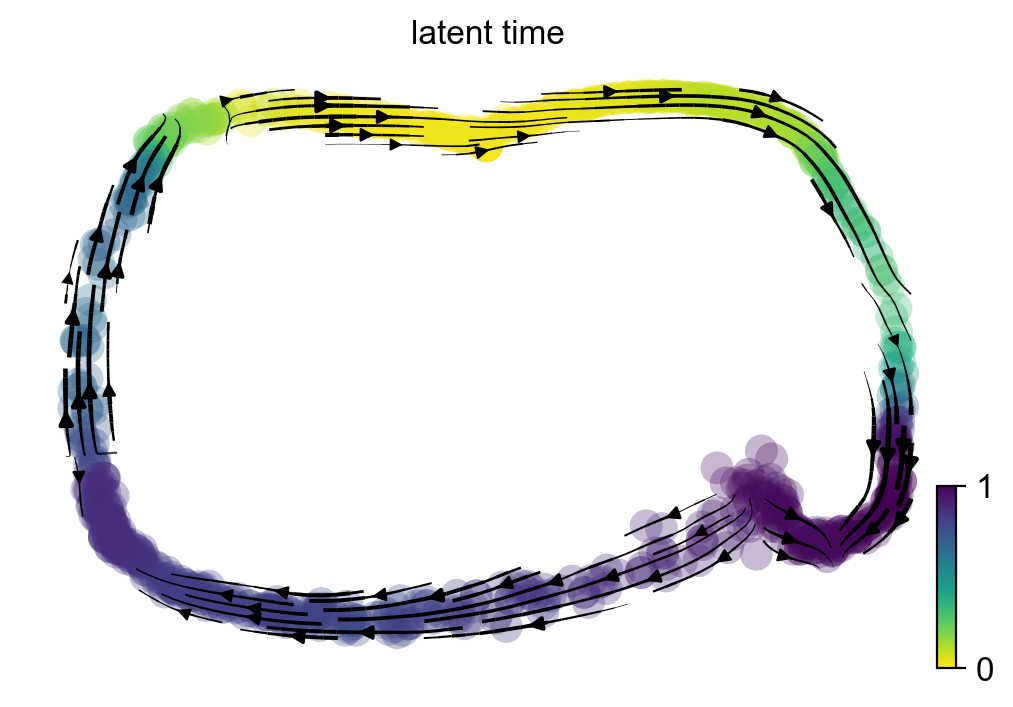

In [572]:
adata_target = get_time_and_velocity(adata,rgv_m,n_samples = 25,sim_dynamics = False)
scv.tl.velocity_graph(adata_target)
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [573]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.15866831346962895, pvalue=4.577200144360311e-07)

In [574]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:157,157:(157*2)])

In [575]:
corr = corr[~np.isnan(corr)]
corr.mean()

0.02582697752528557

In [576]:
GRN = rgv_m.model.v_encoder.mask_m * rgv_m.model.v_encoder.grn

In [577]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [578]:
pre = GRN[rgv_m.model.v_encoder.mask_m==1]

In [579]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [580]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [582]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr((pre.detach().numpy()),(gt))
corr

0.18452753497896088

In [59]:
### run velovi

In [55]:
from velovi import preprocess_data, VELOVI

In [63]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [64]:
adata.layers["Ms"].max()

1.0000001

In [65]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.64it/s, loss=-746, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.44it/s, loss=-746, v_num=1]


In [66]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [67]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


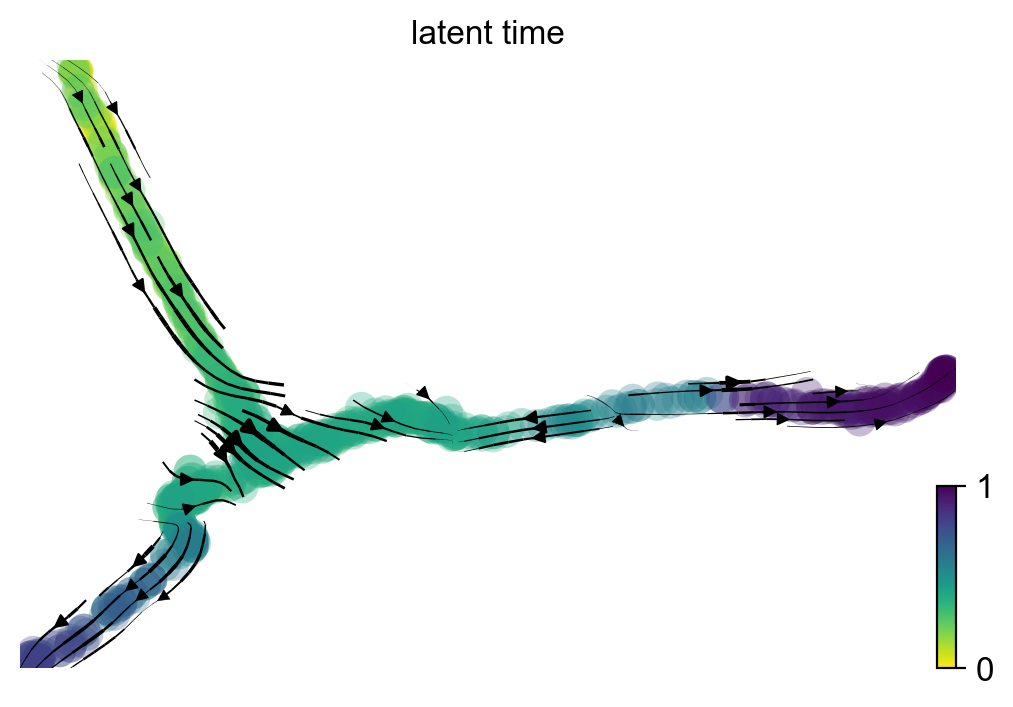

In [68]:
scv.tl.latent_time(adata,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'latent_time')

In [69]:
import scipy
scipy.stats.spearmanr(adata.obs["latent_time"], adata.obs["sim_time"])

SignificanceResult(statistic=0.8546389297340651, pvalue=2.473759398321471e-286)

In [70]:
adata

AnnData object with n_obs × n_vars = 1000 × 155
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred', 'velocity_d

In [422]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:123,123:(123*2)])

In [423]:
corr.mean()

0.08457822806228725

In [421]:
adata

AnnData object with n_obs × n_vars = 1000 × 123
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'Ms', 'Mu', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred',

In [191]:
adata

AnnData object with n_obs × n_vars = 1000 × 200
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'dimred', 'X_pca', 'X_dimred', 'velocity_d

In [708]:
rgv_m.model.v_encoder.grn

Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, -0.0000, -0.0000],
        [0.4142, 0.5125, 0.0000,  ..., 0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, 0.0000, 0.0000,  ..., 0.0000, -0.0000, -0.0000],
        [-0.0000, 0.0000, 0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, 0.0000, 0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       requires_grad=True)

In [462]:
GRN = rgv_m.model.v_encoder.mask_m * rgv_m.model.v_encoder.grn

In [463]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [464]:
pre = GRN[rgv_m.model.v_encoder.mask_m==1]

In [584]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.layers["Ms"].T, adata.layers["Ms"].T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [465]:
pre = corr_m[np.array(adata.uns["skeleton"].T)==1]

NameError: name 'corr_m' is not defined

In [466]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr((pre.detach().numpy()),(gt))
corr

0.5130373635416207

In [34]:
### Run GRNBoost2 on this gene expression dataset

In [17]:
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [18]:
GEP = pd.DataFrame(adata.layers["Ms"],columns = adata.var.index.values)

In [19]:
GEP

,A1_TF1,A1_TF2,A1_TF3,A1_TF4,A1_TF5,A2_TF1,A2_TF2,A2_TF3,A3_TF1,A3_TF2,...,Target46,Target47,Target48,Target49,Target5,Target50,Target6,Target7,Target8,Target9
0,1924.608521,158.576843,2321.012207,3306.411133,1497.879639,848.969116,124.869629,55.069553,155.210785,498.786316,...,209.433167,1348.725220,93.786308,0.346029,0.000000,0.000000,4.081820,224.374512,473.188629,697.005066
1,2405.489746,249.760223,3429.840820,3966.984619,2003.980835,902.091003,199.608047,89.754852,21.097559,105.089996,...,310.406494,1698.461060,165.914749,0.860960,0.277552,0.139069,3.379279,398.540253,529.417542,752.989075
2,2626.085938,225.878860,6283.752441,5378.819336,2753.540527,1317.578125,120.527283,76.813713,0.535159,0.348887,...,402.828949,0.205583,1.001372,0.770192,109.230324,0.000000,5.187024,460.349854,228.755203,792.721497
3,2616.979492,229.840134,3809.496338,4746.137207,2586.660156,1378.208374,199.993271,109.071648,0.000000,0.159004,...,427.476013,1012.778625,378.121338,1.070023,5.433927,10.820313,4.214355,431.981781,297.001831,652.989380
4,2340.255859,335.349884,4126.923340,5787.435059,2140.083496,1426.898560,210.006516,146.725830,0.320970,0.445123,...,392.352936,2289.900391,133.387909,1.004588,36.626537,15.364892,3.689789,475.638336,384.859161,877.300415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2649.418701,236.134430,3364.381592,5908.083008,2693.543945,1528.041138,216.200302,98.650185,0.109117,0.000000,...,418.312561,2009.466797,908.578369,0.524751,27.605679,56.289444,4.909880,472.802032,314.965515,687.332703
996,2420.768066,259.464935,3189.501709,5267.136719,1975.979248,1108.187500,137.152863,110.889015,79.897789,224.519638,...,382.519836,2141.761963,0.000000,0.582101,0.000000,0.000000,3.775799,499.484070,417.924744,787.915710
997,834.027771,107.279175,1245.338623,1983.623413,626.925964,417.604034,46.963284,18.860834,458.771881,922.833984,...,81.325745,1919.375000,0.000000,0.848103,0.000000,0.000000,3.029425,150.311676,403.094727,594.445435
998,2671.308838,363.656189,4150.474609,5661.982910,1979.982300,1440.686401,186.179733,98.212234,10.957718,27.522160,...,503.977478,1880.886597,181.223541,0.424167,0.000000,3.834985,3.918950,619.310913,379.890778,841.436157


In [20]:
network = grnboost2(expression_data=GEP,
                    tf_names=adata.uns["regulators"].tolist())

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [21]:
network

,TF,target,importance
57,B5_TF3,B5_TF2,1.446897e+02
56,B5_TF2,B5_TF1,1.436636e+02
52,B4_TF1,B4_TF2,1.428325e+02
57,B5_TF3,B5_TF1,1.378908e+02
56,B5_TF1,B5_TF3,1.366242e+02
...,...,...,...
25,B11_TF2,A3_TF3,1.065379e-08
29,B11_TF6,B7_TF1,7.993291e-09
62,B6_TF3,D3_TF3,4.856847e-09
28,B11_TF5,B14_TF2,1.066437e-09


In [22]:
ind = [i in adata.uns["targets"] for i in network["target"]]

In [23]:
network = network[ind]

In [24]:
grnboost_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [25]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (network["TF"] == j) & (network["target"] == i)
        if sum(ind) > 0:
            pdd = network[ind]
            grnboost_m.loc[i,j] = pdd["importance"].values

In [26]:
grnboost_m = np.array(grnboost_m)

In [29]:
int_grn = grnboost_m * np.sign(np.array(rgv_m.model.v_encoder.grn.detach()))

In [30]:
int_grn.shape

(250, 135)

In [226]:
grn_boost_pre = grnboost_m[np.array(adata.uns["skeleton"]).T==1]

In [230]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [283]:
corr, _ = stats.spearmanr(abs(grn_boost_pre),abs(gt))
corr

0.303730015300737

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.  

In [1]:
######## running coupling model
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import RegVelo as rgv

Global seed set to 0


In [123]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [124]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [125]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [126]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=210)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 210 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [127]:
adata.X = np.log1p(adata.X.copy())

In [128]:
W = adata.uns["skeleton"].copy()

In [129]:
features = [i in adata.var.index.values for i in adata.uns["regulators"]]
W = W[features,:]
W = W[:,features]

In [130]:
import torch
W = torch.tensor(W).int()

In [131]:
rgv_m = rgv.train.Trainer(adata, loss_mode='mse',W=W.T, solver = "AdamW",early_stopping = False, scheduler = "CyclicLR", batch_size = 128,nepoch = 500, n_latent = 20,lr = 0.01,wt_decay = 0.01)

In [136]:
a = torch.randn(3)
m = torch.randn(2,3)
a * m[0,:]

tensor([ 1.2597, -1.1706, -0.0128])

In [138]:
(a * m).sum(dim=1)

tensor([ 0.0763, -1.6509])

In [132]:
#rgv_m.model.lode_func.fc1.bias.data = torch.nn.Parameter(torch.zeros(210))

In [133]:
#rgv_m.model.lode_func.fc1.bias

In [134]:
rgv_m.train()

Epoch 53:  11%|███▌                              | 53/500 [00:14<02:01,  3.67epoch/s, train_loss=5.94e+8, val_loss=6.06e+8]


KeyboardInterrupt: 

In [111]:
adata.obs["sim_time"]

cell1         0.000000
cell2        78.083333
cell3       372.083333
cell4       172.000000
cell5        92.083333
               ...    
cell996     348.083333
cell997      26.083333
cell998      10.000000
cell999      34.083333
cell1000    390.083333
Name: sim_time, Length: 1000, dtype: float64

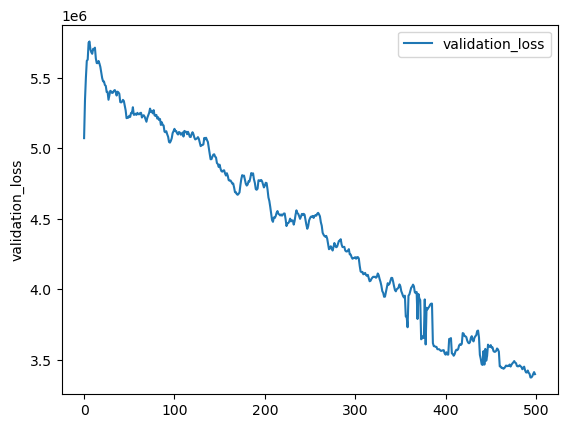

In [112]:
rgv_m.log['validation_loss']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['validation_loss'], label="validation_loss")
ax.set_ylabel("validation_loss")
ax.legend()
plt.show()

In [113]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        new_velo = model.lode_func(T, pred_x).cpu().detach().numpy()
        
        ## insert into the velocity matrix
        insert = [adata.obs.index.tolist().index(i) for i in id]
        for i in insert:
            velo[i,:] = new_velo[i,:]

    return velo

In [114]:
adata.obs["ptime"] = rgv_m.get_time()
velocity = get_vector_field(rgv_m,T=adata.obs['ptime'].values)

In [115]:
velocity = torch.tensor(velocity)

In [116]:
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]

In [117]:
ds.shape

torch.Size([1000, 210])

In [118]:
adata.layers["velocity"] = ds

In [119]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


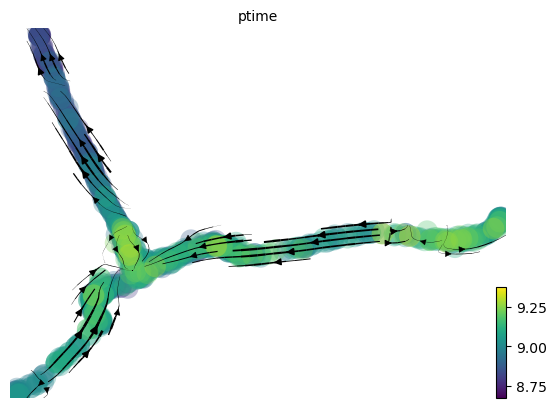

In [120]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'ptime')

In [36]:
import scipy
scipy.stats.spearmanr(adata.obs["ptime"], adata.obs["sim_time"])

SignificanceResult(statistic=0.47871923571087066, pvalue=2.05347711459399e-58)

In [60]:
from scipy.integrate import quad

a = torch.tensor([0.0, 0.0, 0.0])
b = torch.tensor([1.0, 2.0, 3.0])
m = torch.tensor([1.0, 2.0, 3.0])
n = torch.tensor([0.0, 1.0, 2.0])

integral = 1.0
for i in range(3):
    f_i = lambda x_i: m[i] * x_i + n[i]
    result_i, _ = quad(f_i, a[i], b[i])
    print(result_i)

0.49999999727658506
5.999999951657318
19.500000063818113


In [274]:
from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

a = np.zeros([1000])
b = np.arange(1,1001)
m = torch.randn(1000)
n = torch.randn(1000)
simp = Simpson()

for i in range(200):
    f_i = lambda x_i: m[i] * x_i + n[i]
    integration_domain = [[a[i],b[i]]]
    result = simp.integrate(f_i, dim=1, N=101, integration_domain=integration_domain)
    print(result)

tensor(-1.6080)
tensor(-2.2861)
tensor(-8.0806)
tensor(-3.9830)
tensor(-21.3731)
tensor(27.5392)
tensor(2.0759)
tensor(-9.5498)
tensor(-57.3052)
tensor(-55.2715)
tensor(64.8682)
tensor(46.8705)
tensor(-73.7124)
tensor(128.6962)
tensor(19.0706)
tensor(-48.6391)
tensor(25.6907)
tensor(199.0844)
tensor(241.0192)
tensor(-237.6852)
tensor(-281.6215)
tensor(-21.2475)
tensor(395.1408)
tensor(-203.3114)
tensor(-638.7944)
tensor(2.5910)
tensor(403.3328)
tensor(-119.0433)
tensor(-73.7734)
tensor(-417.3760)
tensor(899.9827)
tensor(-201.4562)
tensor(-651.7297)
tensor(-831.1698)
tensor(-1295.7943)
tensor(503.5690)
tensor(-685.5049)
tensor(-172.1779)
tensor(-385.2771)
tensor(85.6408)
tensor(-37.2239)
tensor(-274.5117)
tensor(-414.6545)
tensor(1286.3239)
tensor(-257.8928)
tensor(-905.4982)
tensor(433.7232)
tensor(-980.7626)
tensor(-362.4165)
tensor(-1822.3477)
tensor(-2950.1396)
tensor(-248.7614)
tensor(-74.5948)
tensor(368.2845)
tensor(1181.0715)
tensor(-2.2435)
tensor(1515.5994)
tensor(-1539.6764)


In [354]:
def integral_alpha(b ,m = 1, n=1):
    f_i = lambda x_i: m * x_i + n
    integration_domain = [[0,b]]
    result = simp.integrate(f_i, dim=1, N=101, integration_domain=integration_domain)
    return result

In [358]:
integral_alpha(b_tensor[1])

tensor(4.0000)

In [369]:
rgv_m.model.v_encoder.tau[0,:].view(-1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<ViewBackward0>)

In [335]:
[y[None]][0]

tensor([[0, 1]])

In [376]:
def integral_alpha(b ,m = 1, n=1):
    f_i = lambda x_i: m * x_i + n
    integration_domain = [[0,b]]
    result = simp.integrate(f_i, dim=1, N=101, integration_domain=integration_domain)
    return result

# Define a 1D tensor of values for b
b_tensor = torch.tensor([1, 2, 3, 4, 5])

# Apply the integral_alpha function to each element of the tensor
result_tensor1 = torch.tensor(list(map(integral_alpha, b_tensor)))

result_tensor2 = torch.tensor(list(map(lambda b: integral_alpha(b, m=1), b_tensor)))

In [378]:
result_tensor2

tensor([ 1.5000,  4.0000,  7.5000, 12.0000, 17.5000])

In [330]:
b

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [304]:
x = x.reshape(5,1)

In [325]:
b = torch.tensor(b[0:10])

In [326]:
b

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [322]:
import functorch
fn = functorch.vmap(integral_alpha)

In [327]:
fn(b)

[[0, BatchedTensor(lvl=1, bdim=0, value=
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4],
            [ 5],
            [ 6],
            [ 7],
            [ 8],
            [ 9],
            [10]])
)]]


RuntimeError: vmap: It looks like you're calling .item() on a Tensor. We don't support vmap over calling .item() on a Tensor, please try to rewrite what you're doing with other operations. If error is occurring somewhere inside PyTorch internals, please file a bug report.

In [ ]:
integral_func()

In [276]:
domains = [torch.tensor([[-1.0, y]] * 3) for y in range(5)]
domains

[tensor([[-1.,  0.],
         [-1.,  0.],
         [-1.,  0.]]),
 tensor([[-1.,  1.],
         [-1.,  1.],
         [-1.,  1.]]),
 tensor([[-1.,  2.],
         [-1.,  2.],
         [-1.,  2.]]),
 tensor([[-1.,  3.],
         [-1.,  3.],
         [-1.,  3.]]),
 tensor([[-1.,  4.],
         [-1.,  4.],
         [-1.,  4.]])]

In [272]:
b

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [240]:
def f(x, a, b):
    return ax+b

In [241]:
f_i = f(x ,1,1)

TypeError: unsupported operand type(s) for +: 'AxesSubplot' and 'int'

In [61]:
#velocity_random = tnode2.get_vector_field(adata.obs['ptime'].values)
velocity = get_vector_field(rgv_m,adata.obs['ptime'].values)
#ds_random = velocity_random[:,int(tnode2.n_int/2):tnode2.n_int]
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]
velocity_gt = adata.layers["rna_velocity"]

In [62]:
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), ds)
corr = np.diagonal(corr.statistic[0:210,210:(210*2)])

In [63]:
corr.mean()

0.05350404852419619

In [124]:
adata.shape

(1000, 210)

In [ ]:
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
regulators = adata.var.index.values[regulator_index]
targets = adata.var.index.values[target_index]
## get the overlap index
share_gene = list(set(regulators) & set(targets))
reg_share_index = [element in share_gene for element in regulators]
tar_share_index = [element in share_gene for element in targets]

reg_order_index = [list(regulators[reg_share_index]).index(x) for x in share_gene]
tar_order_index = [list(targets[tar_share_index]).index(x) for x in share_gene]


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import RegVelo as rgv

Global seed set to 0


In [2]:
scv.set_figure_params()

In [3]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 1000 × 280
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts', 'rna_velocity'

In [5]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]

    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    adata = adata[:,np.unique(adata.uns["regulators"].tolist()+adata.uns["targets"].tolist())].copy()
    
    return adata

In [6]:
adata.uns["skeleton"].shape

(280, 280)

In [7]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata.layers["Mu"].max()

1086.6066

In [10]:
adata.X = np.log1p(adata.X.copy())

In [11]:
adata = sanity_check(adata)

In [12]:
adata.uns["skeleton"].shape

(135, 250)

In [13]:
adata.layers["Ms"].max()

39747.324

In [14]:
W = adata.uns["skeleton"].copy()

In [15]:
import torch
W = torch.tensor(np.array(W)).int()

In [16]:
W.shape

torch.Size([135, 250])

In [26]:
rgv_m = rgv.train.Trainer(adata, W=W.T,early_stopping = False, nepoch = 400, solver = "AdamW", lr = 0.01,scheduler="CyclicLR",wt_decay=0.01,batch_size=128,grad_clip = 5,alpha_recon_reg = 1,mac_user = False)

In [27]:
rgv_m.train()

Epoch 400: 100%|█████████████████████████████████| 400/400 [03:52<00:00,  1.72epoch/s, train_loss=5.5e+8, val_loss=5.52e+8]


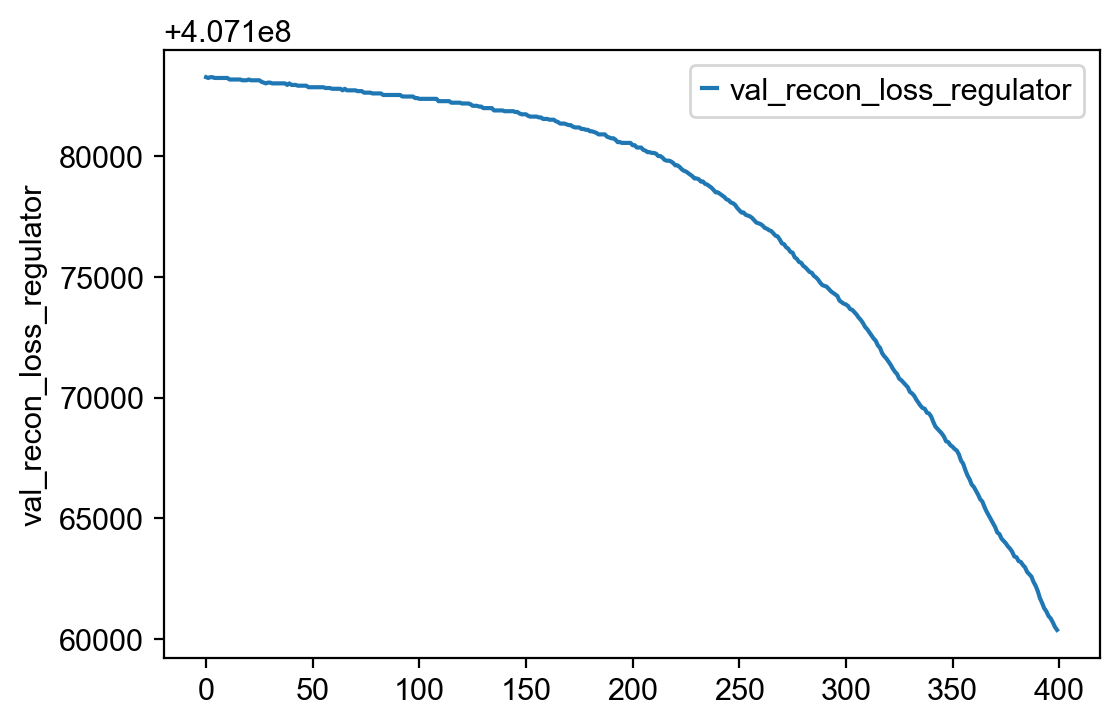

In [30]:
rgv_m.log['val_recon_loss_regulator']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_reg'], label="val_recon_loss_regulator")
ax.set_ylabel("val_recon_loss_regulator")
ax.legend()
plt.show()

In [ ]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    return velo

In [33]:
def get_time(adata, self,n_samples = 1) -> np.ndarray:
    """
    Get the developmental pseudotime for all cells.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated pseudotime of cells.
    """

    self.model.eval()
    X = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    X = torch.tensor(X).to(self.device)
    #ts, _, _ = self.model.encoder(X)
    qz_m, qz_v, z = self.model.z_encoder(X)

    if n_samples > 1:
        qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
        qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
        # when z is normal, untran_z == z
        untran_z = Normal(qz_m, qz_v.sqrt()).sample()
        z = self.z_encoder.z_transformation(untran_z)

    T = self.model.decoder(z).sigmoid() * 20
    return T.detach().numpy()

adata.obs["ptime"] = get_time(adata,rgv_m)

In [34]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        new_velo = model.lode_func(T, pred_x).cpu().detach().numpy()
        
        ## insert into the velocity matrix
        insert = [adata.obs.index.tolist().index(i) for i in id]
        for i in insert:
            velo[i,:] = new_velo[i,:]

    return velo

In [35]:
velocity = get_vector_field(rgv_m,T=adata.obs['ptime'].values)

RuntimeError: The size of tensor a (1000) must match the size of tensor b (135) at non-singleton dimension 0

In [115]:
velocity = torch.tensor(velocity)

In [116]:
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]

In [117]:
ds.shape

torch.Size([1000, 210])

In [118]:
adata.layers["velocity"] = ds

In [119]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


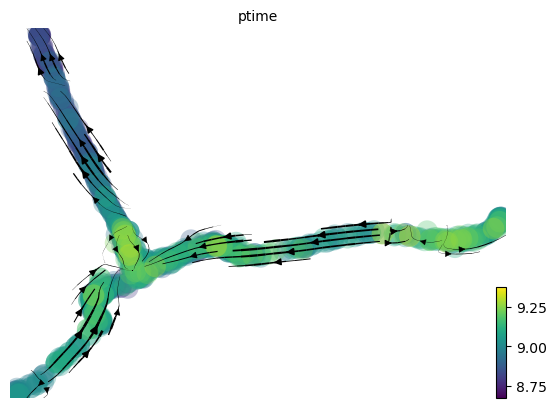

In [120]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'ptime')

In [29]:
for X,Y in rgv_m.train_dl:
    x = X

unspliced = x[:,0:int(x.shape[1]/2)]
spliced = x[:,int(x.shape[1]/2):int(x.shape[1])]

## split spliced matrix into regulator spliced and target spliced
regulator_spliced = spliced[:,rgv_m.model.regulator_index]
target_spliced = spliced[:,rgv_m.model.target_index]
target_unspliced = unspliced[:,rgv_m.model.target_index]

In [30]:
qz_m, qz_v, z = rgv_m.model.z_encoder(x)
qz_logvar = torch.log(qz_v)

T = rgv_m.model.decoder(z) * 20

T = T.ravel()  ## odeint requires 1-D Tensor for time
index = torch.argsort(T)
T = T[index]
x = x[index]
target_spliced = target_spliced[index]
target_unspliced = target_unspliced[index]
#qz_mean = qz_mean[index]
#qz_logvar = qz_logvar[index]
index2 = (T[:-1] != T[1:])
index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
T = T[index2]
x = x[index2]
target_spliced = target_spliced[index2]
target_unspliced = target_unspliced[index2]

In [35]:
from torchdiffeq import odeint
x0 = torch.cat((target_unspliced[0],target_spliced[0]))
#options = get_step_size(self.step_size, T[0], T[-1], len(T))
pred_x = odeint(rgv_m.model.lode_func, x0, T, method = rgv_m.model.ode_method)

In [41]:
x.shape

torch.Size([4, 520])